# Traduction en français du notebook *06* du cours ***Deep Learning*** d'Alfredo Canziani, professeur assistant à la *New York University*  :
https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb

# Aperçu

* Aujourd'hui, nous allons montrer comment entraîner un ConvNet en utilisant PyTorch
* Nous illustrerons également comment le ConvNet utilise des hypothèses spécifiques

# Pour obtenir de bons résultats, nous devons préablablement intégrer certaines connaissances concernant le problème

* Les hypothèses nous aident lorsqu'elles sont vraies
* Elles nous font du mal quand elles ne sont pas
* Nous voulons faire juste la bonne quantité d'hypothèses, pas plus que cela

## En apprentissage profond

* Plusieurs couches : compositionnalité
* Convolutions : localité + stationnarité des images
* Pooling : Invariance de la classe d'objet aux translations

In [2]:
from res.plot_lib import plot_data, plot_model, set_default

In [3]:
set_default()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# fonction pour compter le nombre de paramètres
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Importer le jeu de données (MNIST)

Nous pouvons utiliser certains utilitaires de PyTorch DataLoader pour cela. Cela permettra de télécharger, de mélanger, de normaliser les données et de les classer par batch.

In [6]:
input_size  = 28*28   # images en 28x28 pixels
output_size = 10      # 10 classes (les 10 chiffres)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

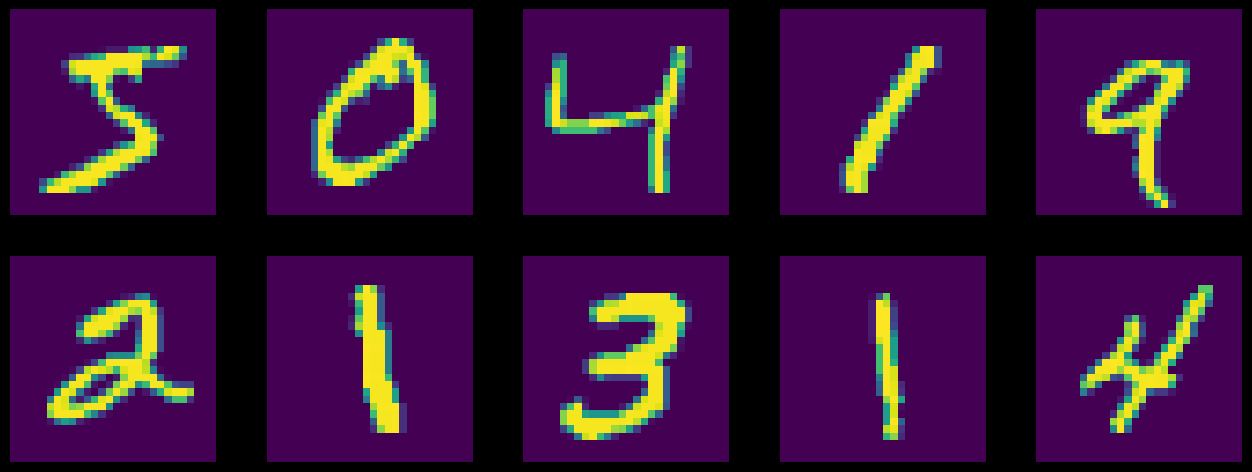

In [7]:
# affichage de quelques images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Création des classes python pour le modèle

In [8]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Fonctionnement sur un GPU 

Dans PyTorch, le passage entre le CPU et le GPU est contrôlé par une chaîne de périphériques, qui déterminera si le GPU est disponible, et reviendra au CPU si ce n'est pas le cas 

In [9]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # envoie au périphérique
        data, target = data.to(device), target.to(device)
        
        # permutation des pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Epoques d entraînement : {} [{}/{} ({:.0f}%)]\tPerte : {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # envoie au périphérique
        data, target = data.to(device), target.to(device)
        
        # permutation des pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nJeu de test : Perte moyenne : {:.4f}, Précision: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Entraîner un petit réseau complètement connecté (fully-connected network)

In [10]:
n_hidden = 8 # nombre d'unités cachées

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Nombre de paramètres : {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Nombre de paramètres : 6442
Epoques d entraînement : 0 [0/60000 (0%)]	Perte : 2.321543
Epoques d entraînement : 0 [6400/60000 (11%)]	Perte : 1.942659
Epoques d entraînement : 0 [12800/60000 (21%)]	Perte : 1.233764
Epoques d entraînement : 0 [19200/60000 (32%)]	Perte : 0.727841
Epoques d entraînement : 0 [25600/60000 (43%)]	Perte : 0.591373
Epoques d entraînement : 0 [32000/60000 (53%)]	Perte : 0.548756
Epoques d entraînement : 0 [38400/60000 (64%)]	Perte : 0.399609
Epoques d entraînement : 0 [44800/60000 (75%)]	Perte : 0.531488
Epoques d entraînement : 0 [51200/60000 (85%)]	Perte : 0.434317
Epoques d entraînement : 0 [57600/60000 (96%)]	Perte : 0.454701

Jeu de test : Perte moyenne : 0.3990, Précision: 8779/10000 (88%)



# Entraîner un ConvNet avec le même nombre de paramètres

In [11]:
# Paramètres d'entraînement 
n_features = 6 # nombre de cartes de caractéristiques (feature maps)

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Nombre de paramètres : {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Nombre de paramètres : 6422
Epoques d entraînement : 0 [0/60000 (0%)]	Perte : 2.316709
Epoques d entraînement : 0 [6400/60000 (11%)]	Perte : 1.734188
Epoques d entraînement : 0 [12800/60000 (21%)]	Perte : 0.696450
Epoques d entraînement : 0 [19200/60000 (32%)]	Perte : 0.413066
Epoques d entraînement : 0 [25600/60000 (43%)]	Perte : 0.254708
Epoques d entraînement : 0 [32000/60000 (53%)]	Perte : 0.282186
Epoques d entraînement : 0 [38400/60000 (64%)]	Perte : 0.213735
Epoques d entraînement : 0 [44800/60000 (75%)]	Perte : 0.161504
Epoques d entraînement : 0 [51200/60000 (85%)]	Perte : 0.215600
Epoques d entraînement : 0 [57600/60000 (96%)]	Perte : 0.408056

Jeu de test : Perte moyenne : 0.2004, Précision: 9364/10000 (94%)



# Le ConvNet est plus performant avec le même nombre de paramètres que le réseau complètement connecté, grâce à l'utilisation de connaissances préalables sur les images

* Utilisation de la convolution : localité et stationnarité dans les images
* Le pooling : intégrer une certaine invariance dans la translation

# Que se passe-t-il si les hypothèses ne sont plus vraies ?

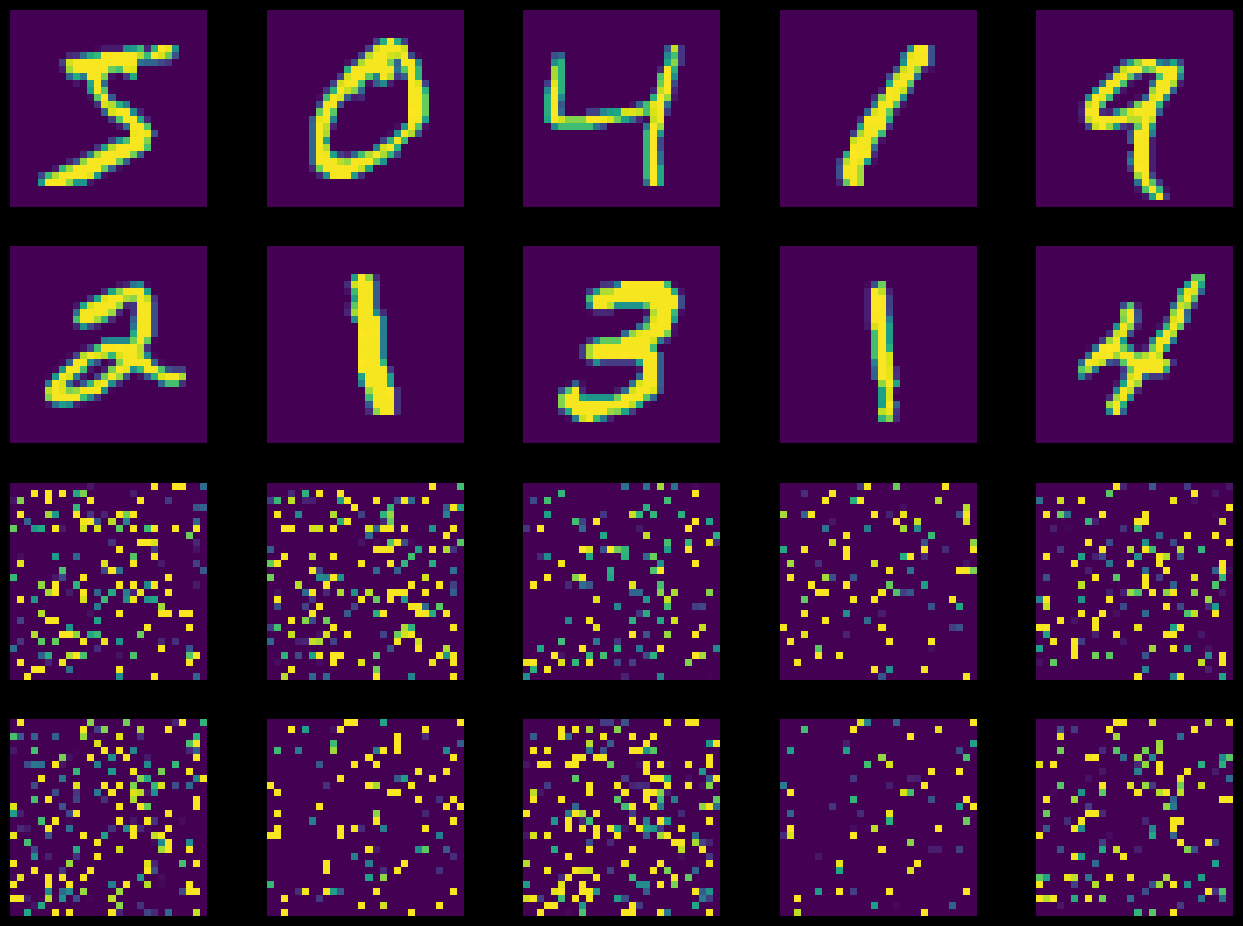

In [12]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permutation des pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet avec  pixels permutés

In [13]:
# Paramètres d'entraînement 
n_features = 6 # nombre de cartes de caractéristiques (feature maps)

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Nombre de paramètres : {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Nombre de paramètres : 6422
Epoques d entraînement : 0 [0/60000 (0%)]	Perte : 2.291638
Epoques d entraînement : 0 [6400/60000 (11%)]	Perte : 2.271657
Epoques d entraînement : 0 [12800/60000 (21%)]	Perte : 2.182901
Epoques d entraînement : 0 [19200/60000 (32%)]	Perte : 1.987215
Epoques d entraînement : 0 [25600/60000 (43%)]	Perte : 1.419999
Epoques d entraînement : 0 [32000/60000 (53%)]	Perte : 1.083868
Epoques d entraînement : 0 [38400/60000 (64%)]	Perte : 0.677264
Epoques d entraînement : 0 [44800/60000 (75%)]	Perte : 0.634720
Epoques d entraînement : 0 [51200/60000 (85%)]	Perte : 0.657610
Epoques d entraînement : 0 [57600/60000 (96%)]	Perte : 0.753816

Jeu de test : Perte moyenne : 0.5452, Précision: 8258/10000 (83%)



# Fully-Connected avec  pixels permutés

In [14]:
n_hidden = 8 # nombres d'unités cachées

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Nombre de paramètres : {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Nombre de paramètres : 6442
Epoques d entraînement : 0 [0/60000 (0%)]	Perte : 2.308519
Epoques d entraînement : 0 [6400/60000 (11%)]	Perte : 2.147758
Epoques d entraînement : 0 [12800/60000 (21%)]	Perte : 1.410200
Epoques d entraînement : 0 [19200/60000 (32%)]	Perte : 1.044632
Epoques d entraînement : 0 [25600/60000 (43%)]	Perte : 0.972731
Epoques d entraînement : 0 [32000/60000 (53%)]	Perte : 0.617678
Epoques d entraînement : 0 [38400/60000 (64%)]	Perte : 0.701452
Epoques d entraînement : 0 [44800/60000 (75%)]	Perte : 0.580374
Epoques d entraînement : 0 [51200/60000 (85%)]	Perte : 0.614139
Epoques d entraînement : 0 [57600/60000 (96%)]	Perte : 0.765751

Jeu de test : Perte moyenne : 0.4914, Précision: 8522/10000 (85%)



# La performance du ConvNet diminue lorsque nous permutions les pixels, mais celle du Fully-Connected Network reste la même

* ConvNet part du principe que les pixels se trouvent sur une grille et sont stationnaires/locaux
* Ses performances baissent lorsque cette hypothèse est fausse
* Le réseau entièrement connecté ne fait pas cette hypothèse
* Il se porte moins bien quand c'est vrai, car il ne tire pas parti de ces connaissances préalables
* Cependant il ne souffre pas lorsque l'hypothèse est fausse

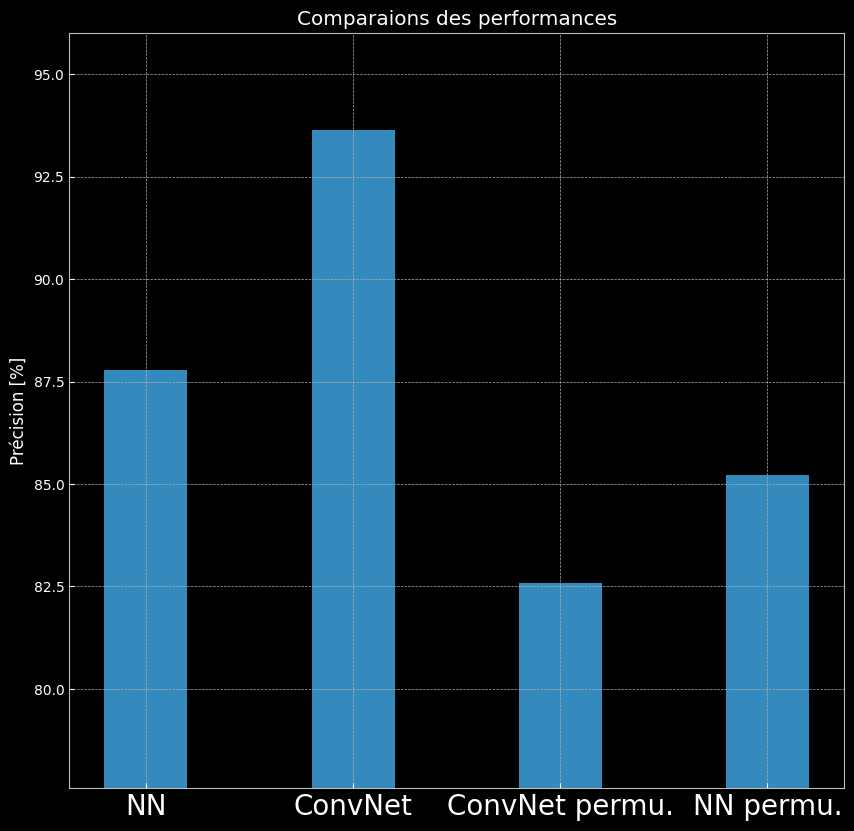

In [15]:
plt.bar(('NN', 'ConvNet',
         'ConvNet permu.', 'NN permu.'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Précision [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Comparaions des performances');

### Vérification des paramètres des modèles

In [16]:
print(dir(model_cnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'conv1', 'conv2', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'fc1', 'fc2', 'float', 'forward', 'half', 'load_state_dict', 'modules', 'n_feature', 'named_buffers', 'name

In [17]:
print(dir(model_fnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'float', 'forward', 'half', 'input_size', 'load_state_dict', 'modules', 'named_buffers', 'named_children', 'named_modules', '